# Introduction

In [3]:
from datetime import datetime
import pandas as pd
import numpy as np

# Stats
import statsmodels.tsa.stattools # for ADF test and coint function
import statsmodels.api # for OLS

# from scipy.stats import norm  # to fit normal dist to data
# import matplotlib.mlab as mlab  # to generate pdfs

# Plotting
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

This report summarises and demonstrates some of the techniques used at arriving at trading strategies using the concepts of _stationarity_ and _cointegration_. In particular, the focus is on energy commodities.

* Section 1 provides details for the datasets used throughout the report
* Section 2 introduces the concept of Stationarity in time series, which  is the key property exploited by cointegration techniques and mean-reverting strategies
* Section 3 goes in detail about Cointegration and how to test for it, as well as assesing its quality
* Section 4 is then dedicated to the application of these concepts to trading strategies and assesing their performance in terms of profit and loss
* Finally the Appendix summarises some of the mathematical methods involved such as Multivariate Regression models (VAR(p), ECM, Augmented Dickey-Fuller Test and Ornstein–Uhlenbeck processes

# Datasets

## Simulated Data

Unless otherwise stated, stochastic processes are simulated with Monte Carlo (MC) where random samples are drawn from the normal distribution.

## Real Data

* For simplicity, only two finacial series are used to demonstrate the concepts. As the focus is on energy commodities, Brent crude and a byproduct (Low Sulphur Gasoil) were selected since they were assumed to be good candidates for cointegration given their deep economic link
* The [Brent](https://www.theice.com/products/219/Brent-Crude-Futures) and [Gasoil](https://www.theice.com/products/34361119/Low-Sulphur-Gasoil-Futures) Futures prices traded in the Intercontinental Exchange (ICE) were taken from  [Quandl's Steven Continuous Series](https://www.quandl.com/data/SCF/documentation/about) using the 'Roll on Last Trading Day with No Price Adjustment' version and the 'Settle' field
* The two series were joined to produce a single dataset consisting of daily settlement prices for Brent and Gasoil
* The dataset spans 1.5 'trading years'. The period selected was Jan-2014 to Dec-2014  for the in-sample testing and Jan-2015 to Jun-2015 for the out-of-sample testing. This was because several sources recommend to use one year of historic data to estimate the cointegration parameters and trade the estimates for a 6-month period, given that the parameters might change over time or the relationship cease to exist
* Dates with missing values after joining the two series were dropped
* Since Gasoil is traded in metric tons and Brent in barrels, the gasoil series was divided by 7.45, which is the [ICE conversion factor](https://www.theice.com/publicdocs/futures/ICE_Gas_Oil_Crack.pdf)

The figure below shows the resulting dataset (spanning both in-sample and out-of-sample periods), where the two series indeed seem to be closely related, having parallel up and down trends.

             brent      gasoil
Date                          
2014-01-02  107.78  123.959732
2014-01-03  106.89  122.181208
2014-01-06  106.73  122.181208
2014-01-07  107.35  122.214765
2014-01-08  107.15  122.449664
            brent     gasoil
Date                        
2015-06-24  63.49  77.986577
2015-06-25  63.20  76.543624
2015-06-26  63.26  77.046980
2015-06-29  62.01  75.771812
2015-06-30  63.59  77.013423


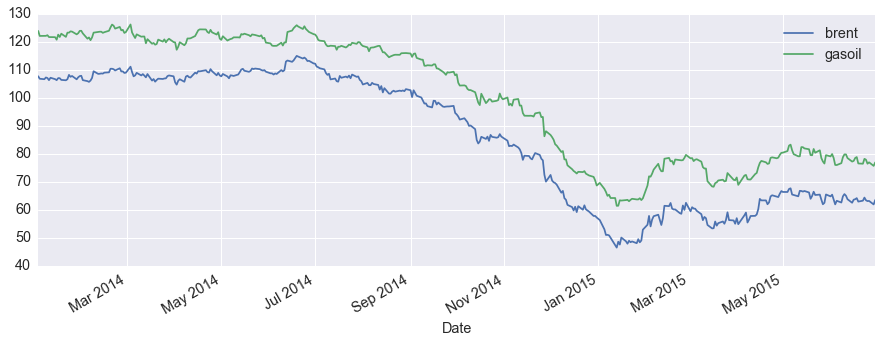

In [50]:
temp = pd.read_csv("data/df_brent_gasoil.csv", index_col=0, parse_dates=True, dayfirst=True)
df = temp[datetime(2014, 1, 1):datetime(2015, 6, 30)]
print df.head()
print df.tail()
_ = df.plot()

# Stationarity and Mean-Reversion

Before cointegration is introduced, it is important to understand the concept of stationarity. A time series is stationary when the parameters of its generating process do not change over time. In particular, its long-run mean and variance stay constant. This property is fundamental when applying linear regression and forecasting models.

Often, processes with a drift or trend, like stock prices, are non-stationary but can be transformed to become stationary. For example, by differencing prices we get returns, which are in general stationary.

The figure below shows how a simulated random walk with drift $Y_t = \alpha + Y_{t-1} + \epsilon_t$ can be made stationary by differencing $Y_t - Y_{t-1} = \alpha + \epsilon_t$

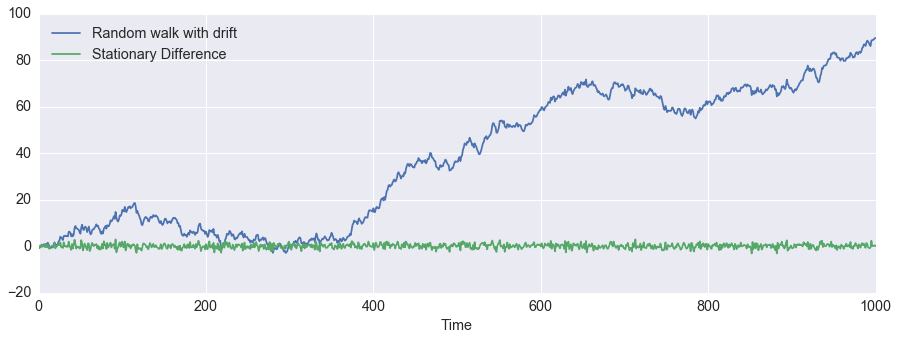

In [51]:
np.random.seed(1000)  # set the seed
M = 1000  # no. of time steps
Y_t = np.zeros((M + 1))
Y_t[0] = 0.0  # initial value
a = 0.1  # drift

for i in xrange(1, M + 1, 1):
    Y_t[i] = a + Y_t[i-1] + np.random.normal(0, 1)

# Y_t = pd.Series(index=range(M), data=Y_t)
Y_t = pd.Series(Y_t, name='Y_t')
_ = Y_t.plot()
_ = Y_t.diff().plot()
# _ = plt.ylabel('Series Value')
_ = plt.xlabel('Time')
_ = plt.legend(['Random walk with drift', 'Stationary Difference'], loc='upper left')

## Mean-Reversion

A stationary series is mean-reverting if over time it drifts towards its long-term mean (the historical equilibrium level). A popular model in this category is the Ornstein–Uhlenbeck (OU) process:

$$
dY_t = \theta(\mu - Y_t)dt + \sigma dW_t
$$

where $\theta$ is the speed of reversion, $\mu$ is the equilibrium level, $\sigma$ the variance and $W_t$ a Wiener Process (Brownian Motion). In a discrete setting this states that the further away the process is from the mean, the greater the 'pull back' to it is. This is in contrast to the random walk above, which has no "memory" of where it has been at each particular instance of time. 

The figure below shows three OU processes with the same mean $\mu=10$ but   different mean-reversion speeds. Indeed it can be noted the highest speed reverts to the mean first. The differences $dY_t$ are plotted below and these appear to become stationary significantly faster than the process itself, almost insensitive to the speed $\theta$.

Therefore, if we are able to transform a time series to be stationary and mean-reverting, we can design trading strategies using these properties which are more independent of market effects. In a later section we shall see how the OU parameters can be used to design exit/entry thresholds and also assess the 'quality' of mean-reversion.

In [52]:
import math
from math import exp, sqrt, log

# MC params
np.random.seed(2000)  # set the seed
dt = 1  # time step
M = 1000  # no. of time steps

# Model params:
mu = 10
sigma = 0.3

Y_t1 = np.zeros((M + 1))
Y_t2 = np.zeros((M + 1))
Y_t3 = np.zeros((M + 1))

Y_t1[0] = -50.0
Y_t2[0] = 50.0
Y_t3[0] = 0.0

theta1 = 0.003
theta2 = 0.01
theta3 = 0.1

for i in xrange(1, M + 1, 1):
    Y_t1[i] = Y_t1[i-1] + theta1 * (mu - Y_t1[i-1]) * dt + sigma * math.sqrt(dt) * np.random.normal(0, 1)
    Y_t2[i] = Y_t2[i-1] + theta2 * (mu - Y_t2[i-1]) * dt + sigma * math.sqrt(dt) * np.random.normal(0, 1)
    Y_t3[i] = Y_t3[i-1] + theta3 * (mu - Y_t3[i-1]) * dt + sigma * math.sqrt(dt) * np.random.normal(0, 1)

# Y_t = pd.Series(index=range(M), data=Y_t)
Y_t1 = pd.Series(Y_t1, name='Y_t1')
Y_t2 = pd.Series(Y_t2, name='Y_t2')
Y_t3 = pd.Series(Y_t3, name='Y_t3')

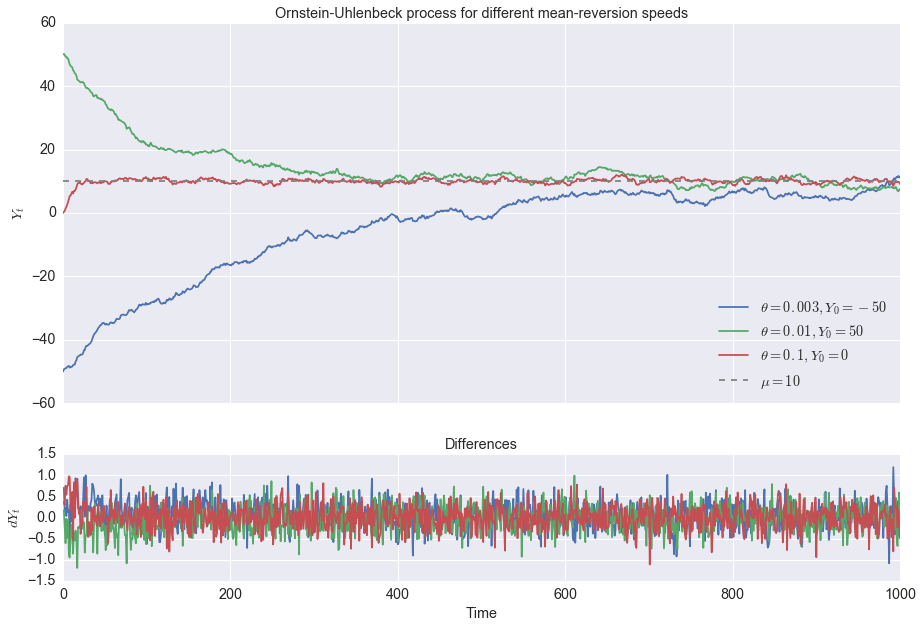

In [53]:
from matplotlib import gridspec

plt.figure(1, figsize=(15, 10))
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
ax = plt.subplot(gs[0])
# plt.subplot(211)

# f, (a0, a1) = plt.subplots(2, 1, gridspec_kw = {'height_ratios':[2, 1]})
# a0.plot(Y_t1)
# a0.plot(Y_t2)
# a0.plot(Y_t3)
# a0.axhline(mu, color='grey', linestyle='--') 
_ = Y_t1.plot()
_ = Y_t2.plot()
_ = Y_t3.plot()
_ = plt.axhline(mu, color='grey', linestyle='--') 

# _ = plt.ylabel('Series Value')
plt.title('Ornstein-Uhlenbeck process for different mean-reversion speeds')
plt.ylabel('$Y_t$')
plt.legend([r'$\theta={0}, Y_0={1:0.0f}$'.format(theta1, Y_t1[0]), 
            r'$\theta={0}, Y_0={1:0.0f}$'.format(theta2, Y_t2[0]),
            r'$\theta={0}, Y_0={1:0.0f}$'.format(theta3, Y_t3[0]),
            r'$\mu={0}$'.format(mu)],
           loc='lower right')

# # plt.subplot(212)
plt.subplot(gs[1], sharex=ax)
plt.title('Differences')
Y_t1.diff().plot()
Y_t2.diff().plot()
Y_t3.diff().plot()
plt.ylabel('$dY_t$')
plt.xlabel('Time')

## Tests

We require a more robust method to confirm statistically whether a series is stationary. Several tests exist, such as the **Augmente Dickey-Fuller (ADF)** test, Phillips–Perron test, Hurst exponent, Kalman filters, etc. 

Here we only implement the ADF test and the mathematical details can be found in the Appendix.

### ADF test implementation

The ADF test equation implemented was:
$$
\Delta Y_t = c_0 + \phi Y_{t-1} + \sum^p_k \phi_k \Delta Y_{t-k} + \epsilon_t 
$$
where a time trend term has not been included due to the nature of financial time series [ref missing](). The coefficients are estimated using the familiar linear regression (see Appendix) whereas the optimal lag order _p_ is discussed below. The python script can be found in  _analysis.py_. All the results were validated against the popular python equivalents from the [statsmodels library](http://statsmodels.sourceforge.net/). 

#### Optimal Lag Selection

Choice of lag order can be a difficult problem. Standard approaches use an _information criteria_, such as the Akaike Information Criterion (AIC). However, different methods can lead to different results. Also, keeping more lags can lead to _model overfitting_. In practice, the choice of optimal lag is also evident from the [Partial Autocorrelation Function](http://nl.mathworks.com/help/econ/autocorrelation-and-partial-autocorrelation.html) (PACF) since the significant lags would show above confidence limits.

Typically for the ADF test it is enough to take _p=1_, however in the interest of exploring this aspect, here we look at the results using AIC an PACF. 

* **AIC:** iterating over different lag orders, the one yielding the lowest AIC value is taken as the optimal lag.  For the simulated random-walk-with-drift and OU processes above the results are summarised in the table below.


In [54]:
%run analysis.py

In [55]:
# GET OPTIMAL LAG for Y_T's

y_list = [Y_t, Y_t1, Y_t2, Y_t3]  # process list
my_lag_list = []
sm_lag_list = []

for y in y_list:
    # Set maximum lag to iterate over 
    # (using default in statsmodels 12*(nobs/100)^{1/4}), from Greene referencing Schwert 1989)
    nobs = y.shape[0]
    maxlag = int(np.ceil(12. * np.power(nobs / 100., 1 / 4.)))
    print 'maxlag tried for {0} = {1}'.format(y.name, maxlag)
    my_bestlag , my_icbest = get_optimal_lag(y, maxlag=maxlag, model='adf')
    sm_result = adfuller(y, maxlag=maxlag, regression='c', autolag='AIC', regresults=True)
    my_lag_list += [(y.name, my_bestlag, my_icbest)]

    sm_bestlag = sm_result[3].usedlag
    sm_icbest = sm_result[3].icbest
    sm_lag_list += [(y.name, sm_bestlag, sm_icbest)]

print my_lag_list
print sm_lag_list

maxlag tried for Y_t = 22
maxlag tried for Y_t1 = 22
maxlag tried for Y_t2 = 22
maxlag tried for Y_t3 = 22
[('Y_t', 22, 2822.9284724156405), ('Y_t1', 1, 510.65130344092904), ('Y_t2', 10, 409.88362605882116), ('Y_t3', 2, 345.78667361444377)]
[('Y_t', 0L, 2792.2436461854049), ('Y_t1', 0L, 498.79608347313001), ('Y_t2', 0L, 401.56429387239655), ('Y_t3', 0L, 322.01280549403577)]


|  Process  |  OU   theta  |  AIC   optimal lag  |
|-----------------|--------------|---------------------|
| Y_t             | 0            | 22                  |
|  Y_t1           | 0.003        | 1                   |
|  Y_t2           | 0.010        | 10                  |
|  Y_t3           | 0.100        | 2                   |

* **PACF:** Given that the optimal lag order from AIC comes out quite high for all, except for Y_t1 and Y_t2, we instead use the empirical results from the PACF plot below, where it can be seen for all only the first lag is well above the 95% confidence band (the first 'spike' represents _p=0_). Given this, we therefore assume it is 'safe' to take _p=1_ to carry out the ADF test.

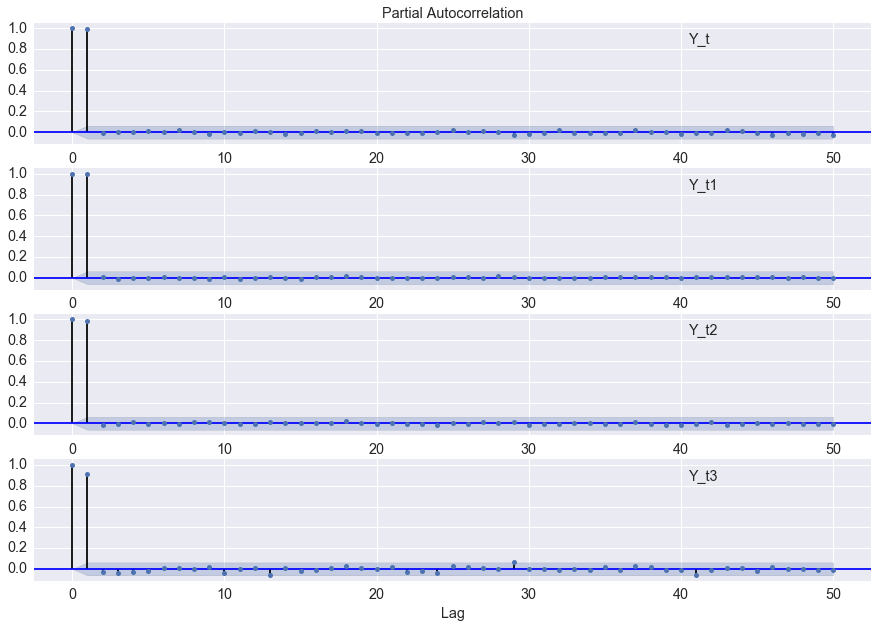

In [56]:
from matplotlib import gridspec
from statsmodels.graphics.tsaplots import plot_pacf

plt.figure(1, figsize=(15, 10))
gs = gridspec.GridSpec(4, 1)

for i, y in enumerate(y_list):       
    ax = plt.subplot(gs[i])
    fig = plot_pacf(y, lags=50, alpha=0.05, ax=ax)
    plt.text(x=40.5, y=0.85, s=y.name, size='x-large')
    if i > 0:
        plt.title("")
#     if i < 3:  # set ticks to invisible
#         plt.xticks([])
#     if i == 1:
#         plt.ylabel("Correlation")
    if i == 3:
        plt.xlabel("Lag")

#### ADF

Using as optimal lag _p=1_, we run the ADF test and compare the corresponding t-statistic to the critical values (taken from statsmodels, based on [MacKinnon (2010)](http://statsmodels.sourceforge.net/stable/generated/statsmodels.tsa.stattools.adfuller.html#statsmodels.tsa.stattools.adfuller)). The results are summarised in the table below, with perhaps an unexpected result for Y_t3 - the OU process with the largest mean-reversion speed is non-stationary under the ADF test. For the rest is as expected. This highlights the need of carrying additional tests for stationarity instead of just relying on one?

In [470]:
my_result = {}  # result using my implementation
sm_result = {}  # statsmodels result

for i, y in enumerate(y_list):
    my_result[y.name] = my_adfuller(y, maxlag=1, regression='c')
    sm_result[y.name] = adfuller(x=y, maxlag=1, regression='c', autolag=None, regresults=True)
    # Also do it for the differences, note different lag used
    my_result['d' + y.name] = my_adfuller(y.diff().dropna(), maxlag=0, regression='c')
    sm_result['d' + y.name] = adfuller(x=y.diff().dropna(), maxlag=0, regression='c', autolag=None, regresults=True)

# Print results
for key in my_result.keys():
    print "{0}: {1:.4f}".format(key, my_result[key]['adfstat'])
    print sm_result[key]
    print "pvalue=%0.4g" % sm_result[key][1]

dY_t2: -29.3639
(-29.36390932844888, 0.0, {'5%': -2.864437475834273, '1%': -3.4369127451400474, '10%': -2.568312754566378}, <statsmodels.tsa.stattools.ResultsStore object at 0x000000002BA8E198>)
pvalue=0
dY_t1: -29.4587
(-29.458702182847425, 0.0, {'5%': -2.864437475834273, '1%': -3.4369127451400474, '10%': -2.568312754566378}, <statsmodels.tsa.stattools.ResultsStore object at 0x000000002DEE00F0>)
pvalue=0
dY_t3: -31.3506
(-31.350558750248219, 0.0, {'5%': -2.864437475834273, '1%': -3.4369127451400474, '10%': -2.568312754566378}, <statsmodels.tsa.stattools.ResultsStore object at 0x000000002F1B01D0>)
pvalue=0
Y_t: 0.1093
(0.10928529332167412, 0.96668935601503581, {'5%': -2.864437475834273, '1%': -3.4369127451400474, '10%': -2.568312754566378}, <statsmodels.tsa.stattools.ResultsStore object at 0x000000002CB5C9E8>)
pvalue=0.9667
Y_t1: -6.0020
(-6.0020080361970347, 1.6488401737025808e-07, {'5%': -2.864437475834273, '1%': -3.4369127451400474, '10%': -2.568312754566378}, <statsmodels.tsa.statt

| Process | Theta | ADF t-stat | 5% Crit. Val. | p-value  | Stationary | Stable |
|---------|-------|------------|---------------|----------|------------|--------|
| Y_t     | 0     | 0.1093     | -2.8644       | 0.9667   | No         | Yes    |
| Y_t1    | 0.003 | -6.0020    | -2.8644       | 1.65E-07 | Yes        | Yes    |
| Y_t2    | 0.01  | -8.7597    | -2.8644       | 2.69E-14 | Yes        | Yes    |
| Y_t3    | 0.1   | -10.1133   | -2.8644       | 9.87E-18 | Yes        | Yes    |
| dY_t    | 0     | -31.8476   | -2.8644       | 0.0      | Yes        | No     |
| dY_t1   | 0.003 | -29.4587   | -2.8644       | 0.0      | Yes        | Yes    |
| dY_t2   | 0.01  | -29.3639   | -2.8644       | 0.0      | Yes        | Yes    |
| dY_t3   | 0.1   | -31.3506   | -2.8644       | 0.0      | Yes        | No     |

#### Stability Check

To ensure further the reliability of results, a stability check can be done on the estimated coefficients by looking at their eigenvalues within the unit circle (see Appendix for details). The results of the self-implementation are displayed in the table above. All cases were found stable, except dY_t and dY_t3. This demonstrates that stationarity does not imply stability. The unstable nature of dY_t may be due to the drift term added $dY_t = \alpha + \epsilon_t$. A close inspection of the problematic root of dY_t3 shows it is just right on the boundary of the unit circle.

In [475]:
for key in my_result.keys():
#     print key, my_result[key]['roots'], sm_result[key][3].roots
    print key, np.abs(my_result[key]['roots'])
    print "{0} passes stability check: {1}".format(key, is_stable(my_result[key]['roots']))

dY_t2 [  1.13343394  22.21695591]
dY_t2 passes stability check: True
dY_t1 [  1.01435783  17.50069413]
dY_t1 passes stability check: True
dY_t3 [   0.99769382  114.54000516]
dY_t3 passes stability check: False
Y_t [ 2.24454786  2.24454786  2.29331194]
Y_t passes stability check: True
Y_t1 [ 2.71044769  3.15598108  3.15598108]
Y_t1 passes stability check: True
Y_t2 [ 2.06150444  2.07651681  2.07651681]
Y_t2 passes stability check: True
Y_t3 [ 1.00769613  1.00769613  1.05473821]
Y_t3 passes stability check: True
dY_t [  0.91600204  11.98589696]
dY_t passes stability check: False


### Other useful plots

When assessing stationarity, the below plots could also be used (see [pandas ref1](http://pandas.pydata.org/pandas-docs/stable/visualization.html#autocorrelation-plot), [pandas ref2](https://github.com/pydata/pandas/blob/master/pandas/tools/plotting.py)):

* **Autocorrelation plot:** this shows the autocorrelation function (ACF) at varying time lags. For perfectly stationary series or iid random variables, the autocorrelations should be near zero for all time-lag separations. The horizontal lines displayed in the plot correspond to 95% and 99% C.L. Indeed in the example below none of the  differenced processes show significant autocorrelation. Also the OU process with the highest mean-reversion speed Y_t3 rapidly looses autocorrelation to its lags, looking more like stationary.

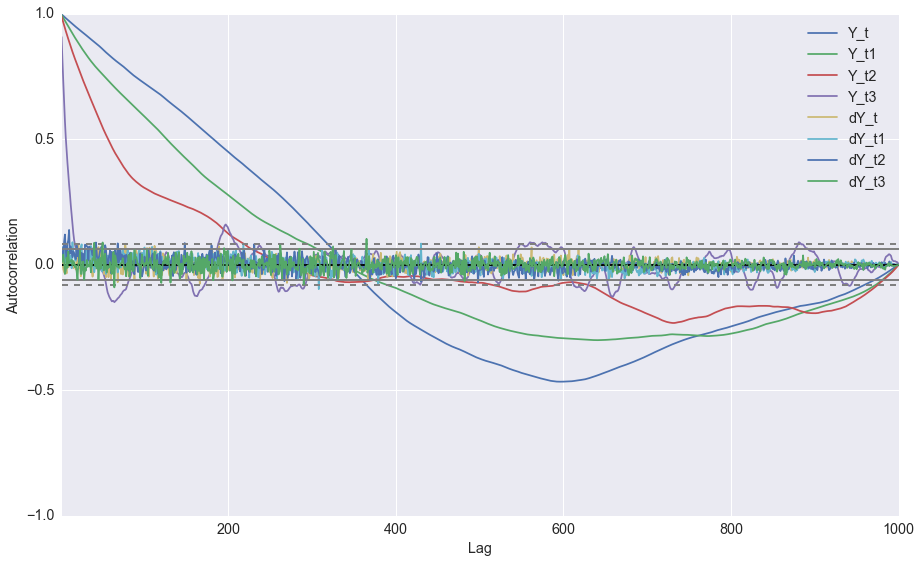

In [356]:
from pandas.tools.plotting import autocorrelation_plot

p_list = [Y_t, Y_t1, Y_t2, Y_t3]

plt.figure(1, figsize=(15, 9))

for i, p in enumerate(p_list):
    autocorrelation_plot(p[1:], label=p.name)

for i, p in enumerate(p_list):
    autocorrelation_plot(p.diff().dropna(), label='d'+p.name)


* **Lag plot:** this is a scatter plot between the series $Y_t$ and one of its lags $Y_{t-p}$. Like in the autocorrelation plot, a stationary series would not exhibit any relationship. Below an example is shown for two of the OU processes and their differences. This confirms the results from the autocorrelation plot - the fastes mean-reverting Y_t3 has little relation to the 10th lag, unlike Y_t1 which has a lower speed. As expected, the stationary differences are insensitive to the lags, even for $Y_{t-1}$.


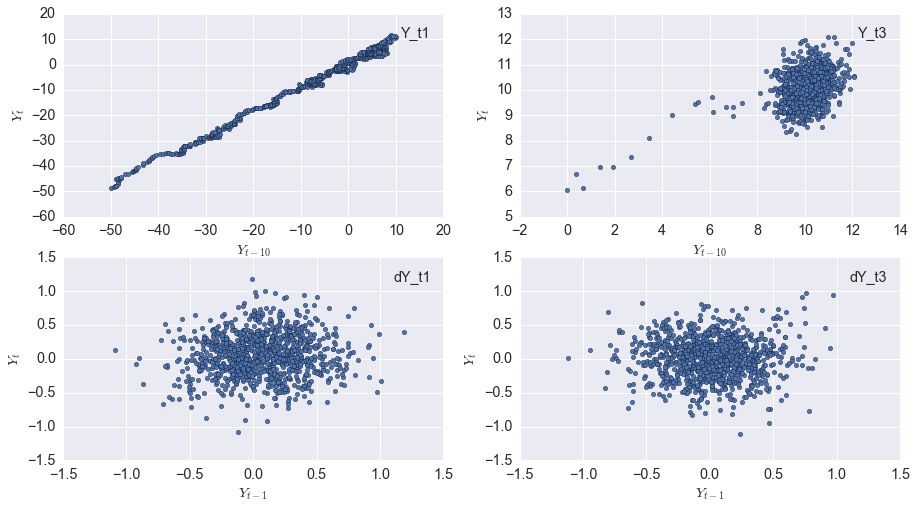

In [421]:
from pandas.tools.plotting import lag_plot

from matplotlib import gridspec

plt.figure(1, figsize=(15, 8))
gs = gridspec.GridSpec(2, 2)

lag_plot(Y_t1, lag=10, ax=plt.subplot(gs[0]), label='Y_t1')
plt.legend(markerscale=0)
plt.xlabel(r'$Y_{t-10}$')
plt.ylabel('$Y_{t}$')
lag_plot(Y_t3, lag=10, ax=plt.subplot(gs[1]), label='Y_t3')
plt.legend(markerscale=0)
plt.xlabel(r'$Y_{t-10}$')
plt.ylabel('$Y_{t}$')
lag_plot(Y_t1.diff().dropna(), lag=1, ax=plt.subplot(gs[2]), label='dY_t1')
plt.legend(markerscale=0)
plt.xlabel(r'$Y_{t-1}$')
plt.ylabel('$Y_{t}$')
lag_plot(Y_t3.diff().dropna(), lag=1, ax=plt.subplot(gs[3]), label='dY_t3')
plt.legend(markerscale=0)
plt.xlabel(r'$Y_{t-1}$')
plt.ylabel('$Y_{t}$')

# Cointegration

Having covered the key concepts to understand cointegration, we proceed to explain this topic.

Two or more time series $\mathbf{Y}_t = (y_{1t}, \dots, y_{nt})^\prime $ are said to be cointegrated if a linear combination exists which makes the collection "integrated of order zero" I(0) i.e stationary:

$$
\mathbf{\beta^\prime Y}_t = \beta_1 y_{1t} + \dots + \beta_n y_{nt} \sim I(0)
$$

This is known as the _long-run (static) equilibrium_ model and is expressed in normalised form as:

$$
y_{1t} = \beta_2 y_{2t} + \dots + \beta_n y_{nt} + e_t
$$

where the residual $e_t \sim I(0)$ is referred to as the _cointegrating residual/spread_ and $\mathbf{\beta} = (1, -\beta_2, \dots, -\beta_n)^\prime$ is the _cointegrating vector_.

In real data, cointegration ususally exists when there is a deep economic link between the assets and hence these cannot drift too far apart because economic forces will act to restore the long-run equilibrium. The figure below shows two simulated cointegrated assets S1 and S2. If S2 is supposed to have a strong link to S1, the price of S2 should vary very similarly. This is modeled by shifting up S1 and adding some 'noise' drawn from a normal distribution.

Due to time constrains, this report only covers the case for 2 time series, however the concept can be extended to more series and higher orders of integration.

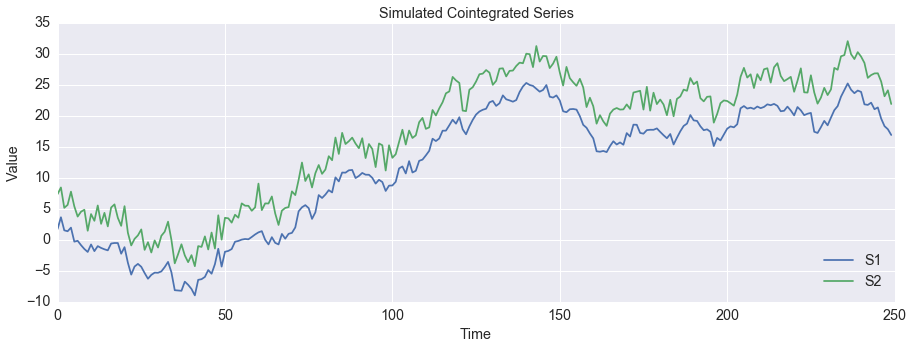

In [41]:
N = 250 # length of series

np.random.seed(2000)

# Generate a stationary random S1
S1 = np.random.normal(0, 1, N)
# Integrate it to make it I(1)
S1 = np.cumsum(S1)
S1 = pd.Series(S1)
S1.name = 'S1'

# Make an S2 that is S1 plus some noise
some_noise = np.random.normal(0, 1, N)
shift = 5.0
S2 = S1 + shift + some_noise
S2.name = 'S2'

plt.plot(S1)
plt.plot(S2)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Simulated Cointegrated Series')
plt.legend([S1.name, S2.name], loc='lower right');

## Tests

Again, we need a robust statistical test to confirm cointegration. The three main approaches are:

* **Engle–Granger two-step method:** this can only be used to test a _single_ cointegrating relationship. The steps are: 

    (i) Estimate the cointegrating residual $ \hat{e}_t = \mathbf{\hat{\beta}^\prime} \mathbf{Y}_t$, e.g. using linear regression

    (ii) Test $\hat{e}_t$ for stationarity, e.g. using the ADF test, where the hypotheses to be tested are:

    $$
    \begin{equation}
    H_0 \space :  \space \hat{e}_t = \mathbf{\hat{\beta}^\prime} \mathbf{Y}_t \sim I(1) \qquad \mathrm{(no \space cointegration)} \\
    H_1 \space :  \space \hat{e}_t = \mathbf{\hat{\beta}^\prime} \mathbf{Y}_t \sim I(0) \qquad \mathrm{(cointegration)}
    \end{equation}
    $$
   

* **Johansen test:** based on maximum likelihood techniques, this allows for more than one cointegrating relationship, but  it is subject to asymptotic conditions when if the sample size is too small


* **Phillips–Ouliaris test:** uses a modified version of the Dickey-Fuller distribution to test the cointegrated spread for stationarity. This is a better choice when dealing with small samples

In this project only the Engle-Granger two-step method is considered.

### Engle-Granger test implementation

For our simulated cointegrated series, assuming these are represented by the vector $\mathbf{Y}_t= (S_1, S_2) = (y_{1t}, y_{2t})$, where we defined $y_{2t}$ as the dependent variable. The cointegration relationship is then repesented by the regression:

$$
y_{1t} = c + \beta_2^\prime y_{2t} + e_t
$$
whose parameters are estimated  using OLS. This yields the estimated cointegrating residual:

$$
\hat{e}_t = y_{1t} - \hat{c} - \hat{\beta}_2^\prime y_{2t}
$$

which we then test for stationarity using the ADF procedure described above.  Since the mean of $\hat{e}_t$ is zero, the ADF test is implemented without a constant or trend (See [ref p445](file:///C:/Users/Tanya.Sandoval/Downloads/Cointegration%20-%20Book%20Chapter%20-%20UWashington%20E%20Zivot.pdf)). Also note that the ADF critical values used are taken as in statsmodels from MacKinnon (2010) [(see ref)](http://statsmodels.sourceforge.net/stable/generated/statsmodels.tsa.stattools.adfuller.html#statsmodels.tsa.stattools.adfuller), whereas other sources suggest to use the Phillips-Ouliaris tabulation for the cointegrating spread.

The figure below shows the OLS fit for S1 and S2, and the estimated cointegrating spread $\hat{e}_t$. The parameters estimates were $\hat{c} = 5.03$ and $\hat{\beta}_2 = 1.01$ (their true values being $5.0$ and $1.0$ respectively). Although the PACF showed no lag order was significant, conservatively the ADF t-statistic was computed using one lag. This was -12.0509, which was below any of the 10%, 5% and 1% critical values. Hence this confirmed the stationarity of the spread, which by design we of course expected.

In [85]:
# My OLS and ADF implementatin
from analysis import my_OLS
from analysis import my_adfuller

# Import statsmodels equivalents to validate results
from statsmodels.tsa.tsatools import add_constant
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import adfuller

# ============= ENGLE-GRANGER COINTEGRATION TEST =============

# Do OLS
y_1t = S2  # dependent variable ('Y')
y_2t = S1  # explanatory variable ('X')

y_2t = add_constant(y_2t)
my_res_ols = my_OLS(y_1t, y_2t)
sm_res_ols = OLS(y_1t, y_2t).fit()  # validate result with statsmodels
y_2t = y_2t.iloc[:, 1]  # remove the constant now that we're done

# Set values of estimated parameters
c_hat = my_res_ols['params'][0]
beta2_hat = my_res_ols['params'][1]
# cointegration spread, should be == sm_res_ols.resid ==  my_res_ols['resid_hat']
e_t_hat = y_1t - c_hat - beta2_hat*y_2t

# print my_res_ols['params']
# print sm_res_ols.params
# print my_res_ols['resid_hat'].head()
# print sm_res_ols.resid.head()
# print e_t_hat.head()

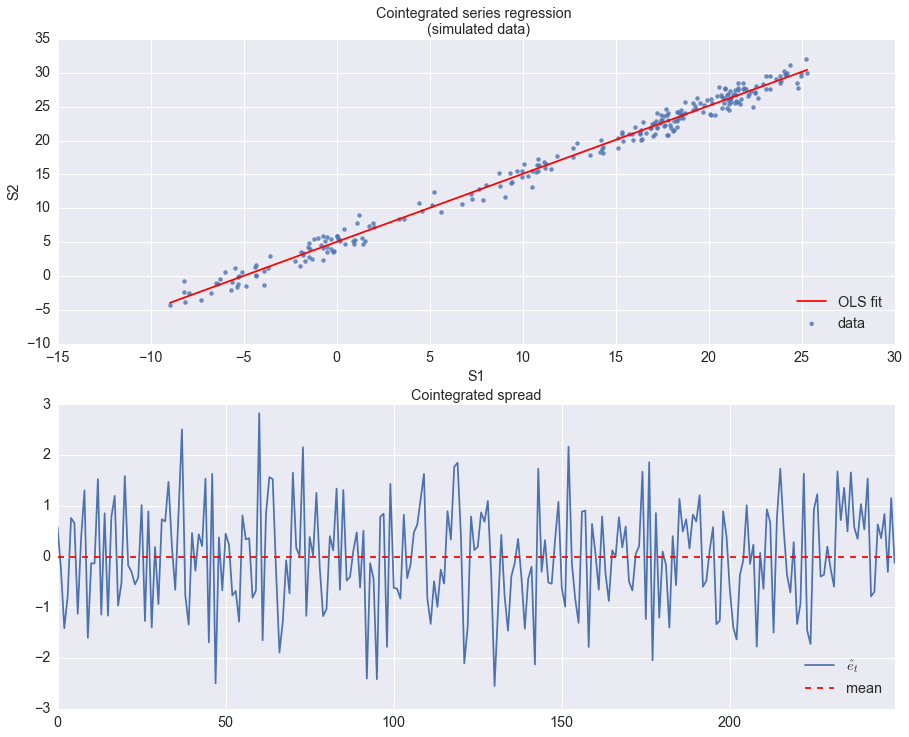

In [71]:
from matplotlib import gridspec

plt.figure(1, figsize=(15, 12))
# gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
gs = gridspec.GridSpec(2, 1)

# lag_plot(Y_t1, lag=10, ax=plt.subplot(gs[0]), label='Y_t1')

# generate equally spaced X values between true X range
x = np.linspace(y_2t.min(), y_2t.max(), 100)

# Plot the estimated dependent variable
y_1t_hat = c_hat + beta2_hat*x

# Plot own fit on top of seaborn scatter + fit
plt.subplot(gs[0])
plt.title('Cointegrated series regression \n (simulated data)')
ax = sns.regplot(x=y_2t, y=y_1t, fit_reg=False)  # true values
ax.plot(x, y_1t_hat, 'r')
plt.legend(['OLS fit', 'data'], loc='lower right')

# Plot cointegrated residual
plt.subplot(gs[1])
plt.title('Cointegrated spread')
e_t_hat.plot()
plt.axhline(e_t_hat.mean(), color='red', linestyle='--') # Add the mean
plt.legend(['$\hat{e}_t$', 'mean'], loc='lower right')

In [73]:
# Test spread for stationarity with ADF assuming maxlag=1
my_res_adf = my_adfuller(e_t_hat, maxlag=1, regression='nc')

# Validate result with statsmodels
sm_res_adf = adfuller(e_t_hat, maxlag=1, regression='nc', autolag=None, regresults=True)

print sm_res_adf
print my_res_adf['adfstat']
# print "%0.4f" % my_res_adf['adfstat']

# # Check optimal lag order
# from statsmodels.graphics.tsaplots import plot_pacf
# _ = plot_pacf(e_t_hat, lags=50, alpha=0.01)
# # plt.text(x=40.5, y=0.85, s=y.name, size='x-large')

(-12.050868021596958, 5.7204620264072049e-22, {'5%': -1.9421357293965669, '1%': -2.5748142943548387, '10%': -1.6157914965824409}, <statsmodels.tsa.stattools.ResultsStore object at 0x000000001A6C5E48>)
-12.0508680216


## Error Correction Model (ECM)

Cointegration implies the existence of an Error Correction Model (ECM), which  provides an adjustment to the long-run equilibrium from the short-run dynamics. This is particularly useful when modelling non-stationary series, like market prices, which can lead to spurious regression results. 

Suppose the cointegrated pair is represented by $\mathbf{Y}_t = (y_t, x_t)^\prime $. One can arrive at the ECM result as follows:

* Consider a dynamic regression model to allow for a wide variety of dynamic patterns in the data. This is done by including lags for both $x_t$ and $y_t$:

$$
y_t = \alpha y_{t-1} +  \beta_0 + \beta_1 x_t + \beta_2 x_{t-1} + \epsilon_t
$$

* By knowing the above equation should be consistent with the long-run equilibrium model $y_t = b_0 + b_1 x_t + e_t$, it can be rewritten as:

    $$
    \Delta y_{t} = \beta_1 \Delta x_t - (1- \alpha) e_{t-1} + \epsilon_t
    $$
    
    where $e_{t-1}$ is the lagged cointegrating spread from the equilbrium model. The parameter $-(1-\alpha)$ is interpreted as the speed of correction towards the equilibrium level (more detais on next section)
    
    
*  Since all the variables in the ECM are I(0), OLS can be used to estimate the parameters


## Quality assessment

How useful the 
If the cointegrating spread $e_t$ is stationary, it means it should have similar properties to the OU process discussed earlier. Hence, we can attempt fitting the spread to the OU process and use the estimated parameters to give an indication of the its 'quality':

* Quality of mean-reversion is associated with the ECM term

* Cointegration is a filter on data - mean-reversion is of lower frequency than the data

can help to assess the 'quality of mean-reversion'.  

The estimated parameters like the speed $\theta$, equilibrium level $\mu_e$ can be used to define trading entry and exit levels and a half-life $tau$ to assess the quality of mean reversion, together with the equilibrium level $\mu_e$ around which mean-reversion occurs. 

* Fitting recipe uses AR(1) model - A.12

* 

* Speed of reversion  can be used to define position exit/entry thresholds in trading strategies as explained in the next section.

It can be shown that the OU fit matches the features of the ECM term

## Granger Causality

When implementing the regression to estimate $e_t$ an assumption must be made about which the dependent variable is. This will also influence the parameters estimates and test results.

Due to time constrains this was not self-implemented but used the python statsmodels implementation.

## Regime changes

Tests for cointegration assume that the cointegrating vector is constant during the period of study. In reality, it is possible that the long-run relationship between the underlying variables change (shifts in the cointegrating vector can occur). The reason for this might be technological progress, economic crises, changes in the people’s preferences and behaviour accordingly, policy or regime alteration, and organizational or institutional developments. This is especially likely to be the case if the sample period is long.

## Real Data Example

The same methods applied above for simulated data are now applied to the real dataset. 

# Trading Strategies